In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib.colors as colors
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]
e = const.physical_constants['elementary charge'][0]

pathPre = '/home/robert/CU-PWFA/emittance_preservation/simulations/WitnessDelay/1.34e16/'

In [2]:
beam_sigmaz = np.array([5.2, 7.8, 10.4])
witness_delay = np.array([220, 230, 240, 250, 270])
gradient = np.zeros((len(beam_sigmaz), len(witness_delay)))

In [3]:
def alpha_colormap(cmap, cutoff, flip=True):
    N = cmap.N
    cmapt = cmap(np.arange(N))
    alpha = np.ones(N)
    if flip:
        temp = alpha[:int(cutoff*N)]
        M = len(temp)
        alpha[:int(cutoff*N)] = np.linspace(0, 1, M)
    else:
        alpha[int((1-cutoff)*N):] = 0.0
    cmapt[:, -1] = alpha
    cmapt = colors.ListedColormap(cmapt)
    return cmapt

def beam_current(i):
    print(0.5e-9*c/(np.sqrt(2*np.pi)*beam_sigmaz[i]*1e-6))

def plot_sim(i):
    N = len(witness_delay)
    plt.figure(figsize=(18,8), dpi=300)
    gs = gridspec.GridSpec(4, N)
    
    for j in range(N):
        path = pathPre + '%0dumX%0.1fum/' % (witness_delay[j], beam_sigmaz[i])
        data = np.load(path + 'AcceleratingGradient.npy').item()
        ind = len(data['energy'])-1
        gradient[i, j] = (data['energy'][ind] - data['energy'][7])/(data['x'][ind] - data['x'][7])
        density = np.load(path + 'DensitySlice.npy').item()

        # Load in plasma density
        ind = 13
        rhoXY = -np.transpose(density['rhoP'][ind]/e/1e6)+2 #+2 makes it greater than 0 for log scale
        x = density['xfield']
        y = density['yfield']
        
        #Load in the beam densities
        rhoBXY = -np.transpose(density['rhoB'][ind]/e/1e6)
        
        ax1 = plt.subplot(gs[0, j])
        plt.plot(data['x']*1e6, data['energy']/1e3)
        if j == 0:
            plt.ylabel('Energy (GeV)')
        plt.xlabel(r'z ($\mu m$)')
        plt.title('%0dum' % (witness_delay[j]))
        plt.twinx()
        plt.plot(data['x'][1:]*1e6, data['gradient']/1e3, 'm')
        if j == N-1:
            plt.ylabel('Gradient (GeV/m)')

        plt.subplot(gs[1, j])
        #for k in range(len(data['x'])):
        k = 6
        plt.plot(data['xfield']*1e6, data['field'][k, :]/1e9, label=('%0.2f' % (data['x'][k]*1e6)))
        if j == 0:
            plt.ylabel('Field (GeV/m)')
        plt.xlabel(r'z ($\mu m$)')

        plt.subplot(gs[2, j])
        plt.plot(data['x']*1e6, data['gamma_rms'], 'g')
        plt.xlabel(r'z ($\mu m$)')
        if j == 0:
            plt.ylabel('Energy spread (%)')
        
        ax = plt.subplot(gs[3, j])
        ax.imshow(rhoXY, interpolation='gaussian', aspect='auto', extent=[-150, 150, -150, 150],
           norm=colors.LogNorm(vmin=5e15, vmax=5e17), cmap='inferno')
        cmapW = alpha_colormap(plt.cm.get_cmap('rainbow'), 0.1, True)
        ax.imshow(rhoBXY, interpolation='gaussian', aspect='auto', extent=[-150, 150, -150, 150], cmap=cmapW)
        plt.xlabel(r'z ($\mu m$)')
        if j == 0:
            plt.ylabel(r'x ($\mu m$)')
        plt.tight_layout()
        
    plt.show()

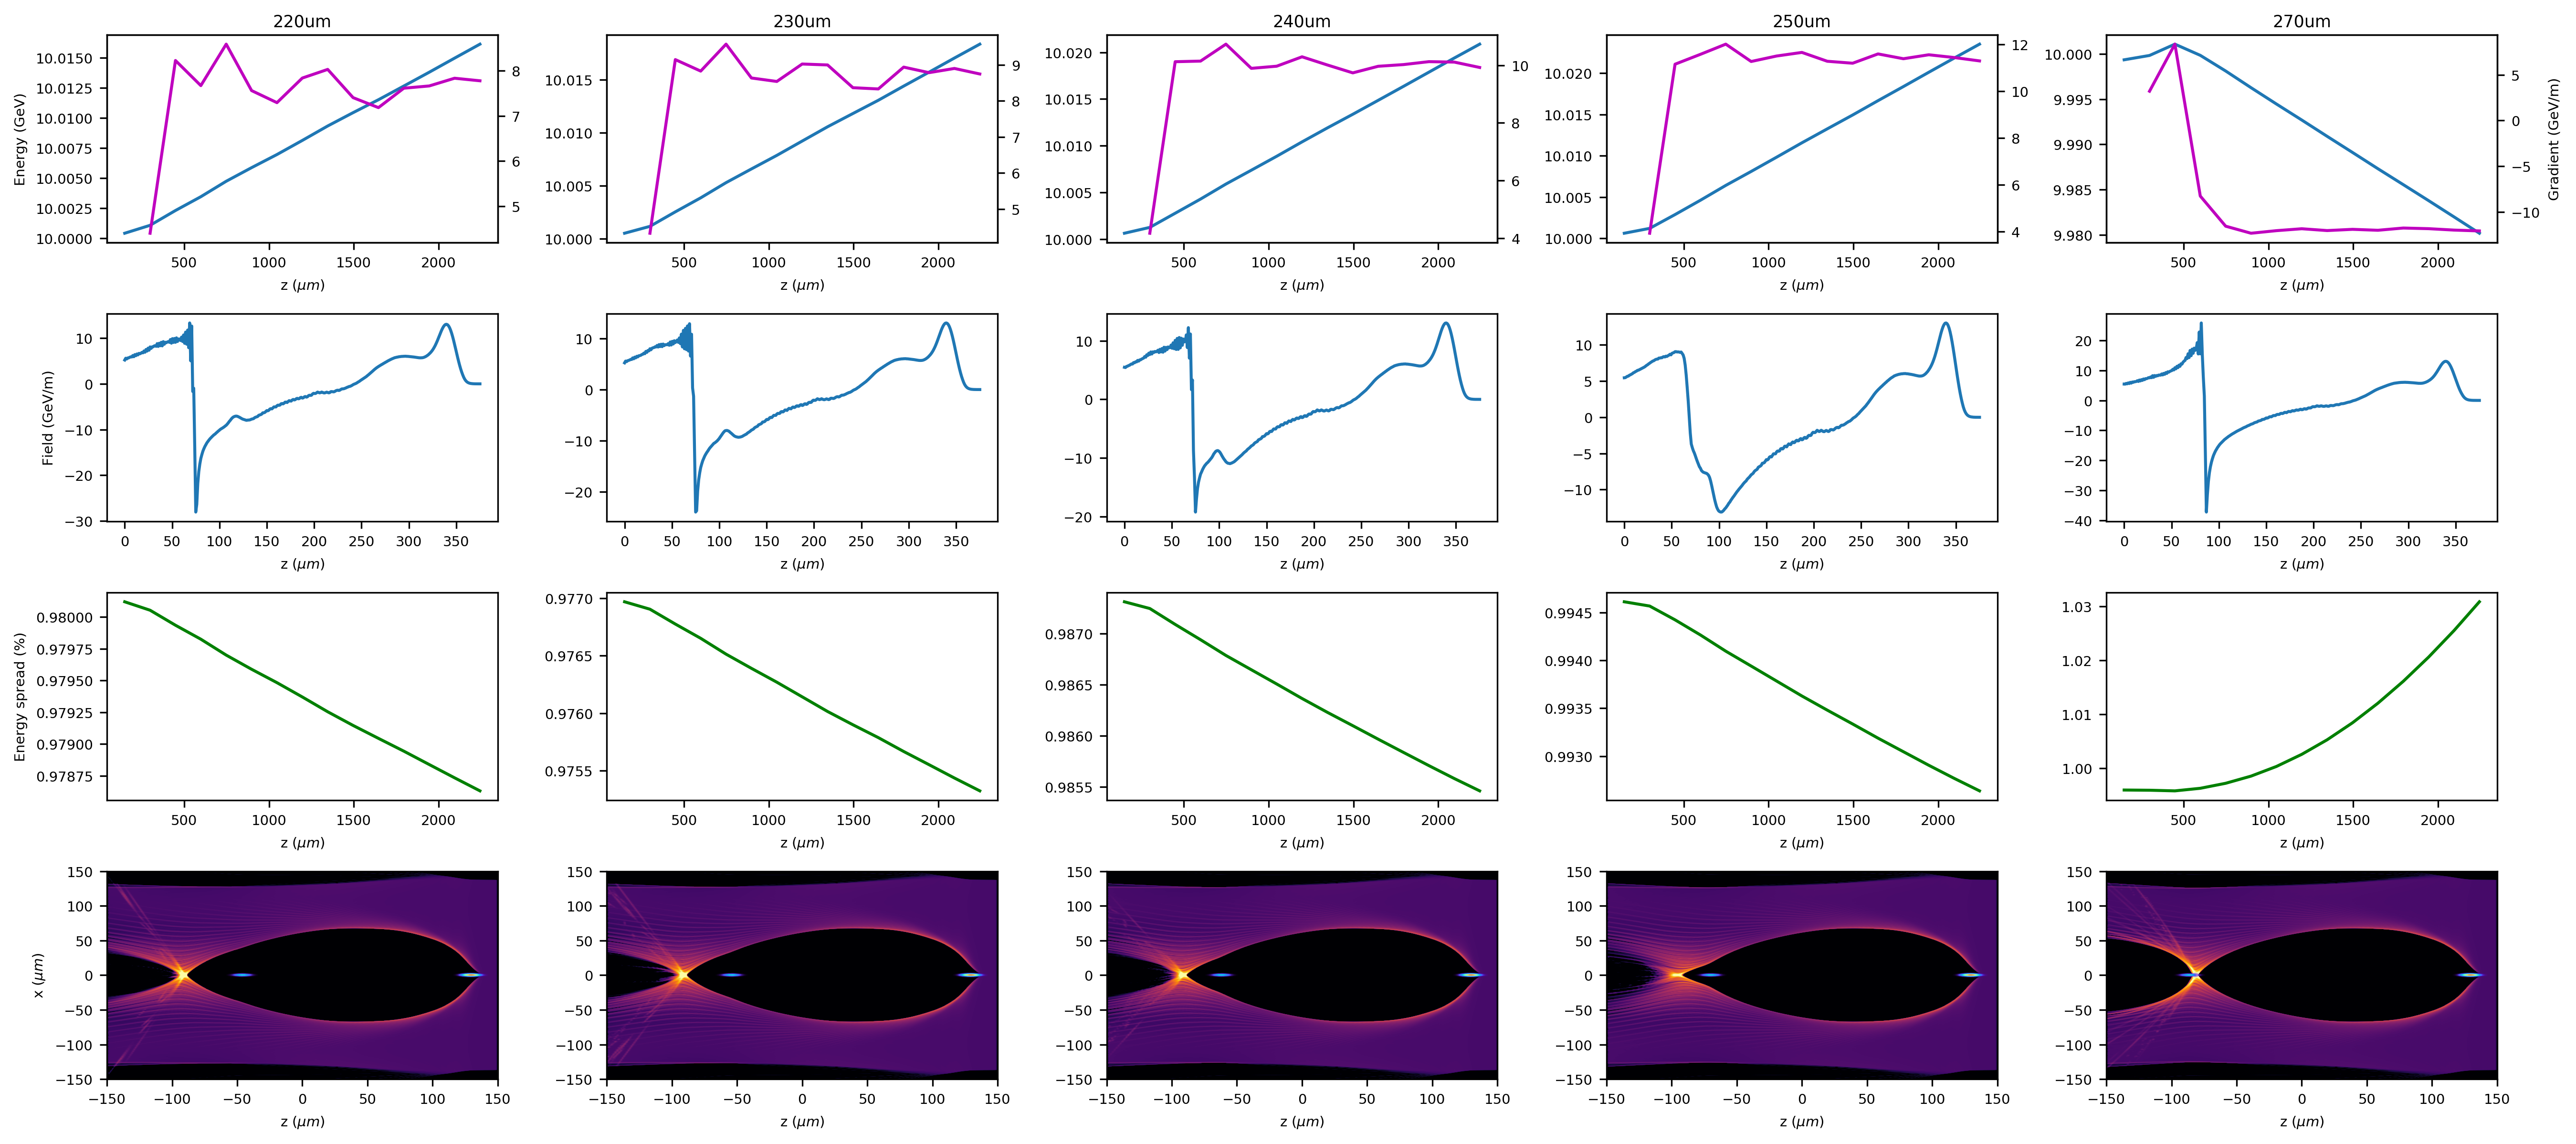

11499.9891194


In [4]:
plot_sim(0)
beam_current(0)

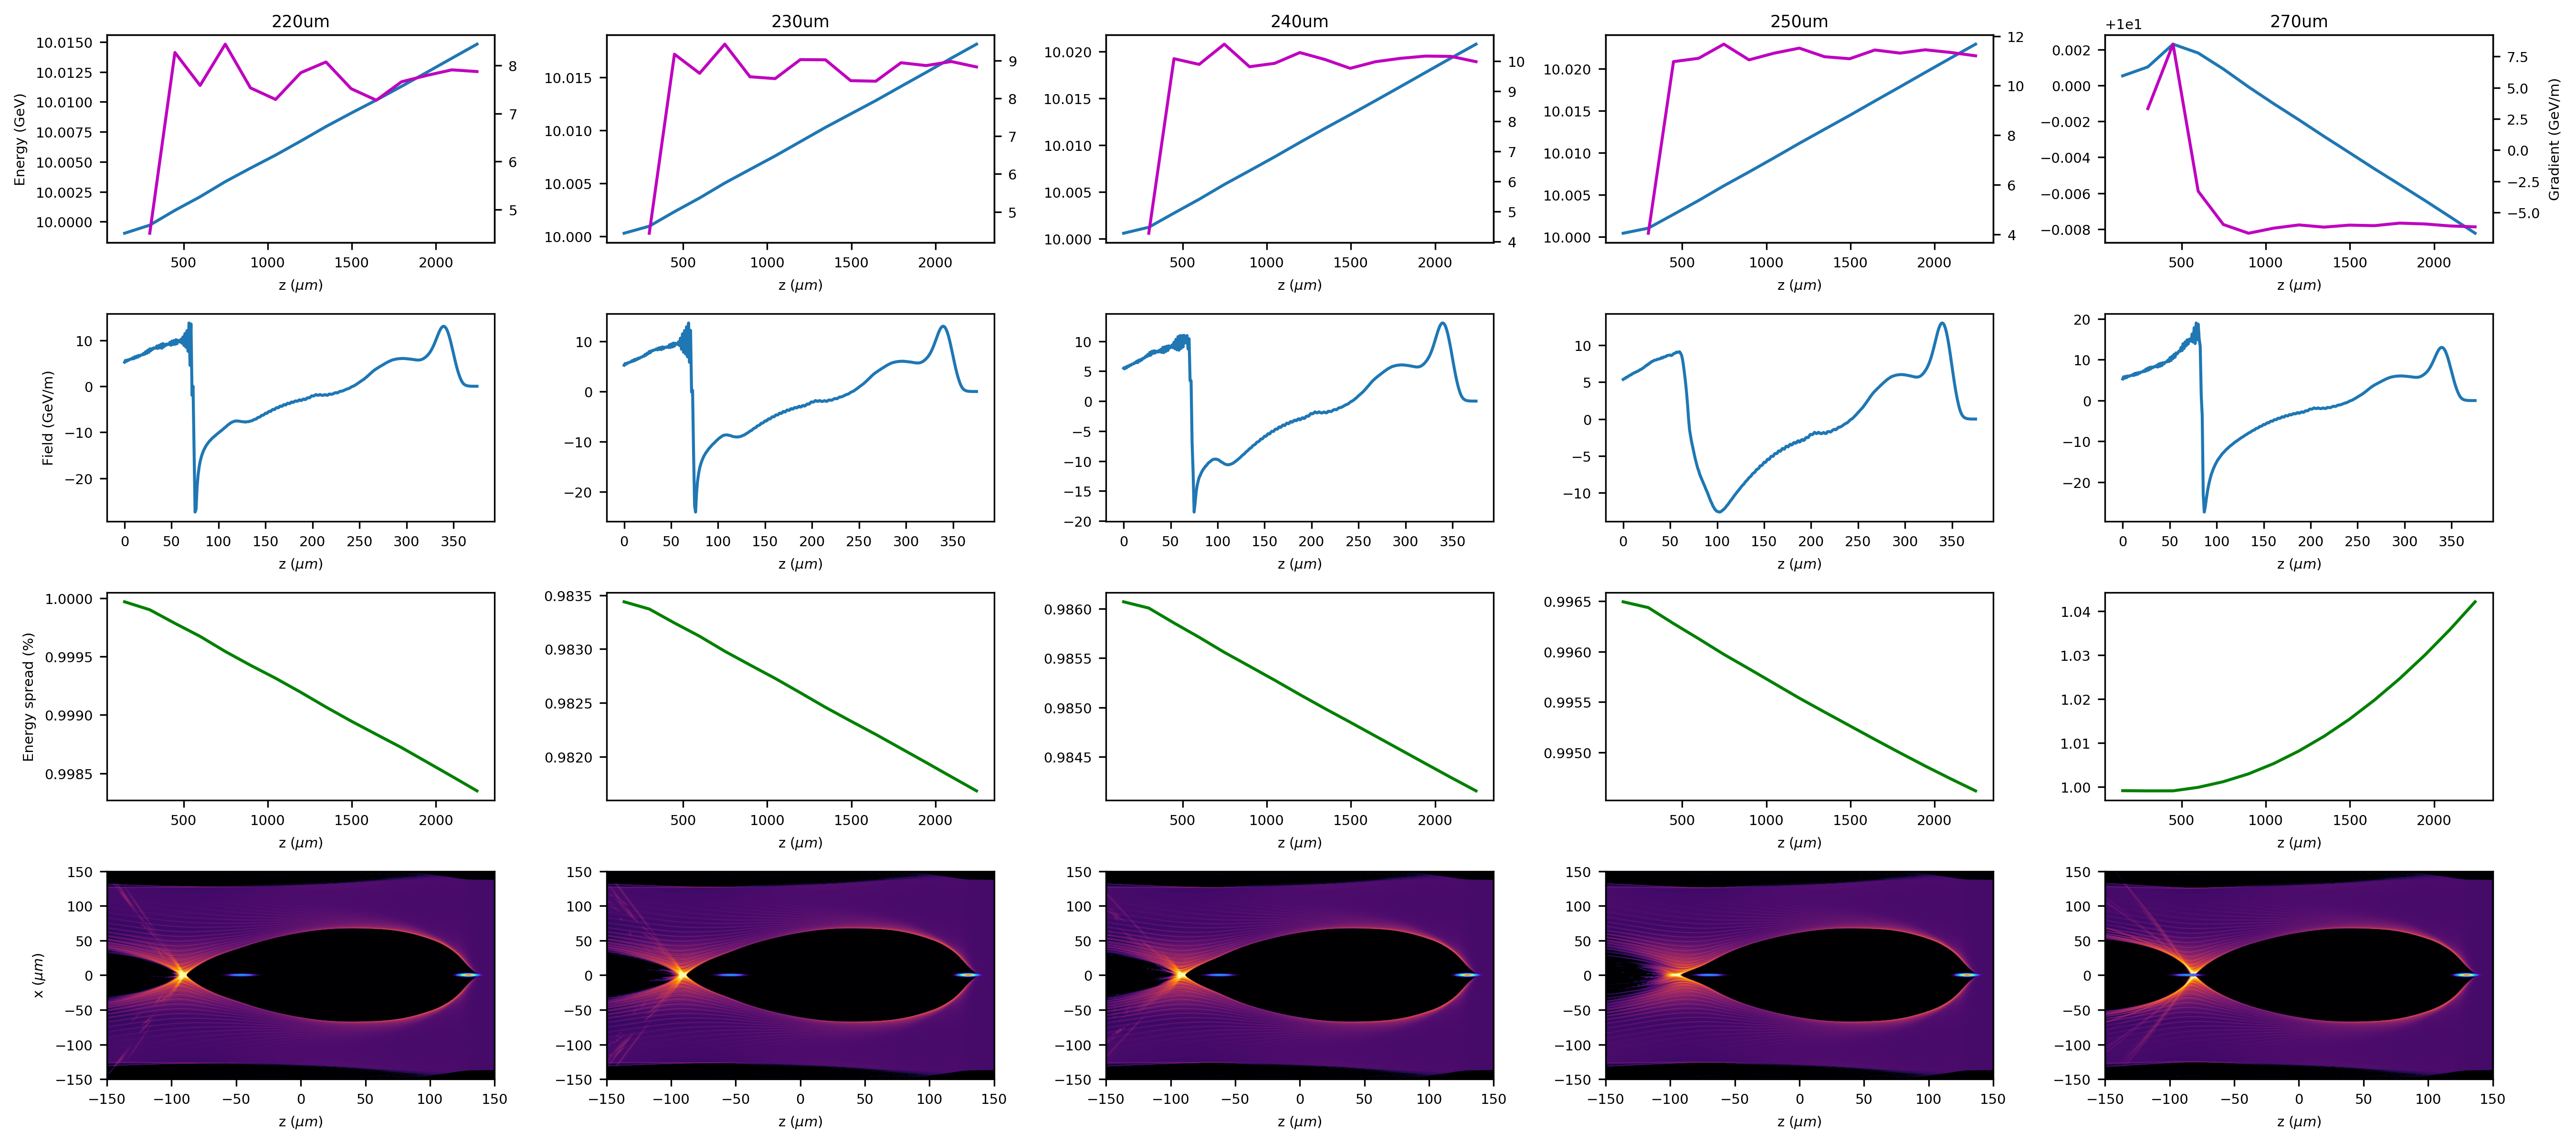

7666.65941293


In [5]:
plot_sim(1)
beam_current(1)

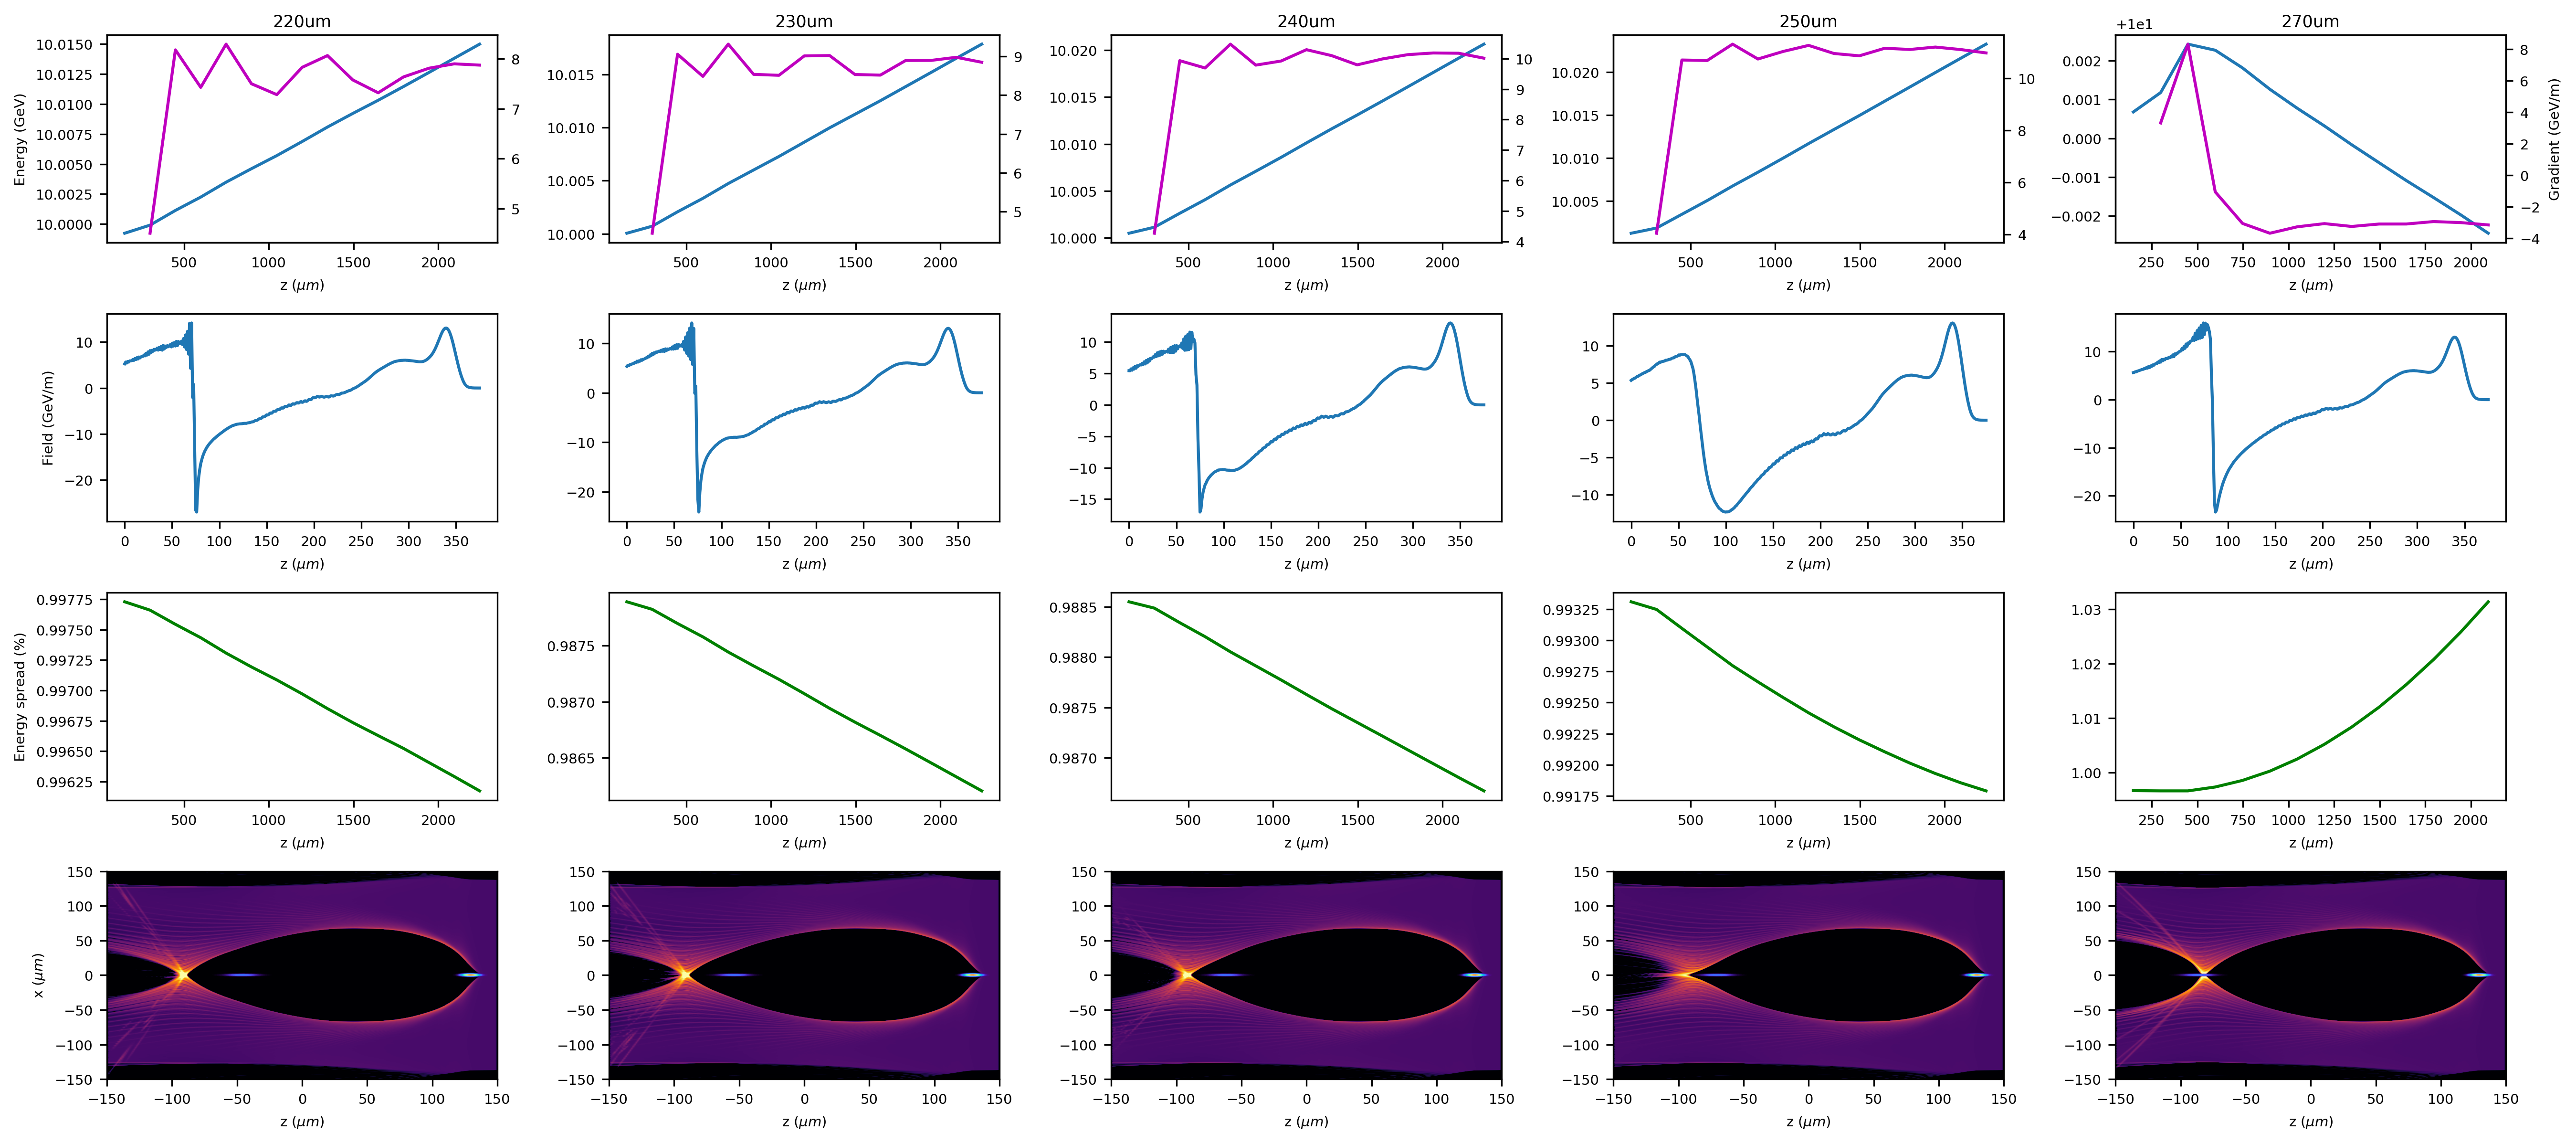

5749.9945597


In [6]:
plot_sim(2)
beam_current(2)

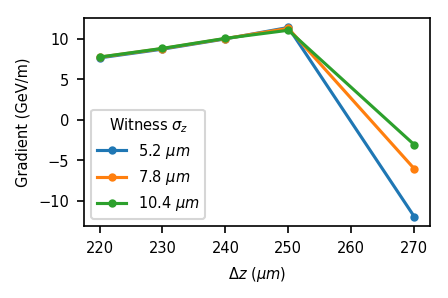

In [7]:
plt.figure(figsize=(3,2), dpi=150)
for i in range(len(beam_sigmaz)):
    plt.plot(witness_delay, gradient[i, :]/1e3, label=(r'%0.1f $\mu m$' % beam_sigmaz[i]), marker='o', markersize=3)
plt.ylabel('Gradient (GeV/m)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.legend(title=r'Witness $\sigma_z$')
plt.tight_layout()
plt.show()

In [8]:
# Look at the accelerating field in the vicinity of the beam to determine wake loading
# I want a better way to quantify the loading, I'll try energy spread after 10GeV of acceleration
spread = np.zeros((len(beam_sigmaz), len(witness_delay)))

def plot_energy_spread(i):
    N = len(witness_delay)
    plt.figure(figsize=(12,4), dpi=150)
    gs = gridspec.GridSpec(2, 3)
    
    
    for j in range(N):
        path = pathPre + '%0dumX%0.1fum/' % (witness_delay[j], beam_sigmaz[i])
        data = np.load(path + 'AcceleratingGradient.npy').item()
               
        plt.subplot(gs[int(j/3), j%3])
        k = 6
        plt.plot(data['xfield']*1e6, data['field'][k, :]/1e9, label=('%0.2f' % (data['x'][k]*1e6)))
        if j%3 == 0:
            plt.ylabel('Field (GeV/m)')
        plt.xlabel(r'z ($\mu m$)')
        plt.ylim(-30, 0)
        plt.twinx()
        
        center = 375-witness_delay[j]-26
        centerInd = int(center*350/375)
        size = 5*beam_sigmaz[i]
        beamDensity = np.exp(-(data['xfield']*1e6-center)**2/(2*beam_sigmaz[i]**2))
        plt.plot(data['xfield']*1e6, beamDensity, 'm')
        if j%3 == 2:
            plt.ylabel('Beam density')
        plt.xlim(center-size, center+size)
        plt.title('%0dum' % (witness_delay[j]))
        
        # Calculate the standard deviation in energy after acceleration
        L = -10/data['field'][k, centerInd]*1e9
        finalE = -data['field'][k, :]/1e9 * L + 10.0
        Eavg = np.average(finalE, weights=beamDensity)
        Estd = np.sqrt(np.average((finalE-Eavg)**2, weights=beamDensity))
        Erel = Estd/Eavg*100
        spread[i ,j] = Erel
        plt.text(center+size-2*beam_sigmaz[i], 0.2, r'$\sigma_E=%0.1f$' % Erel)
        
    plt.tight_layout()
    plt.show()

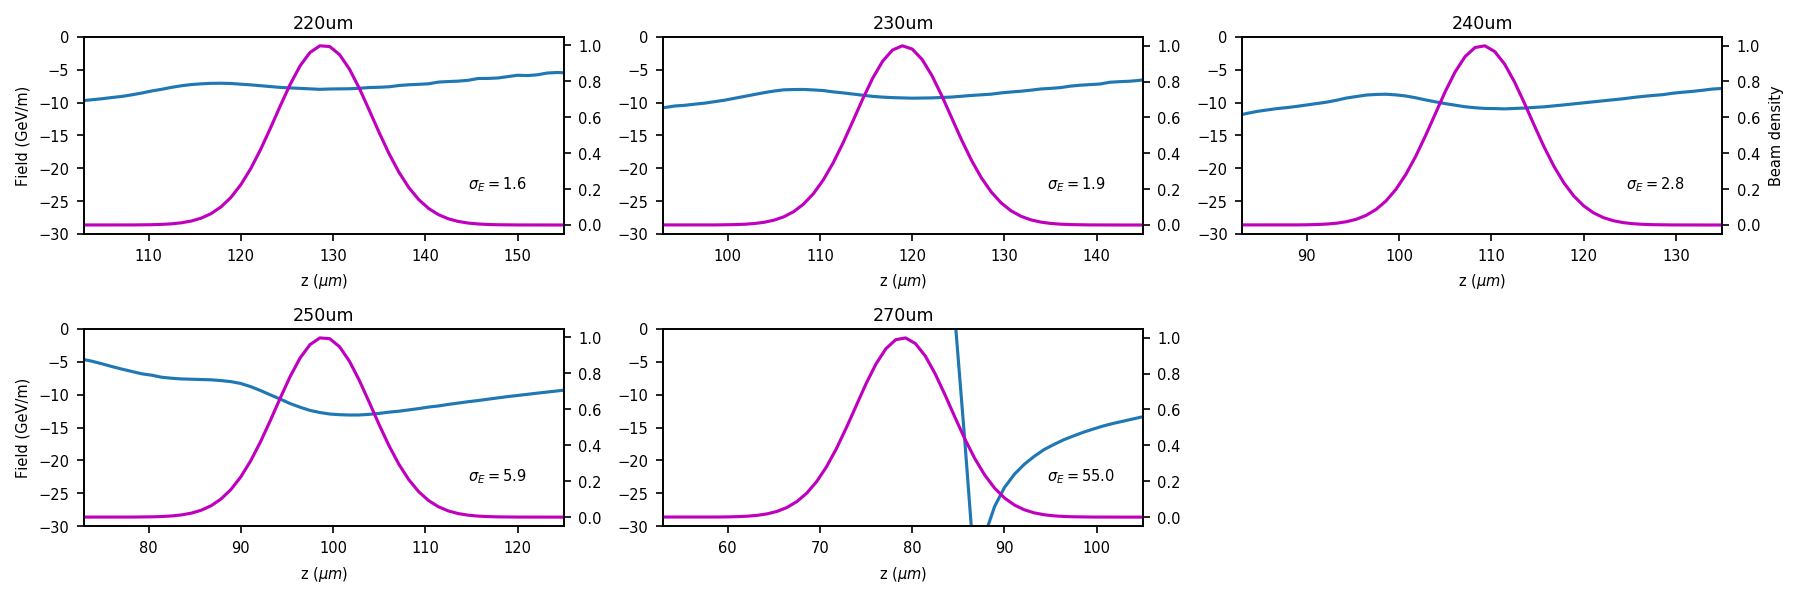

In [9]:
plot_energy_spread(0)

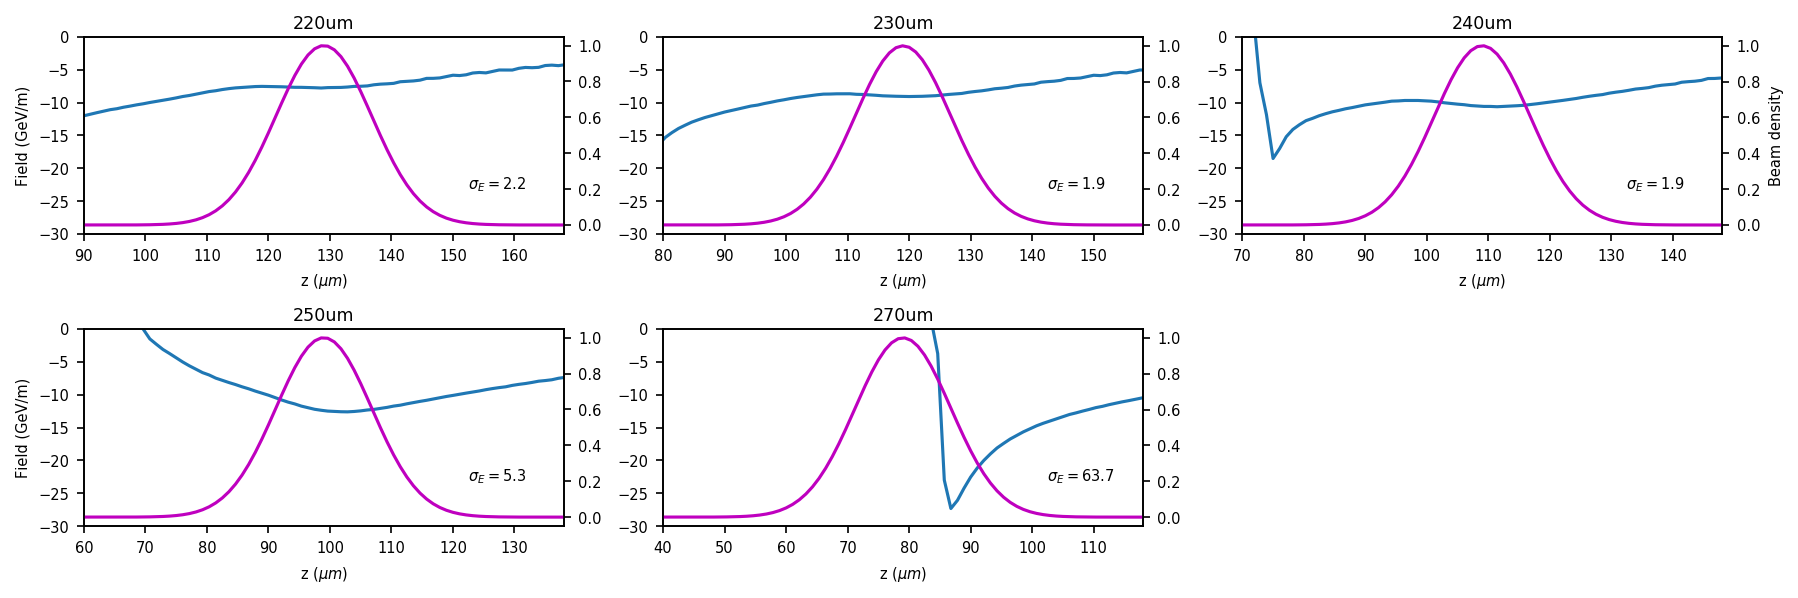

In [10]:
plot_energy_spread(1)

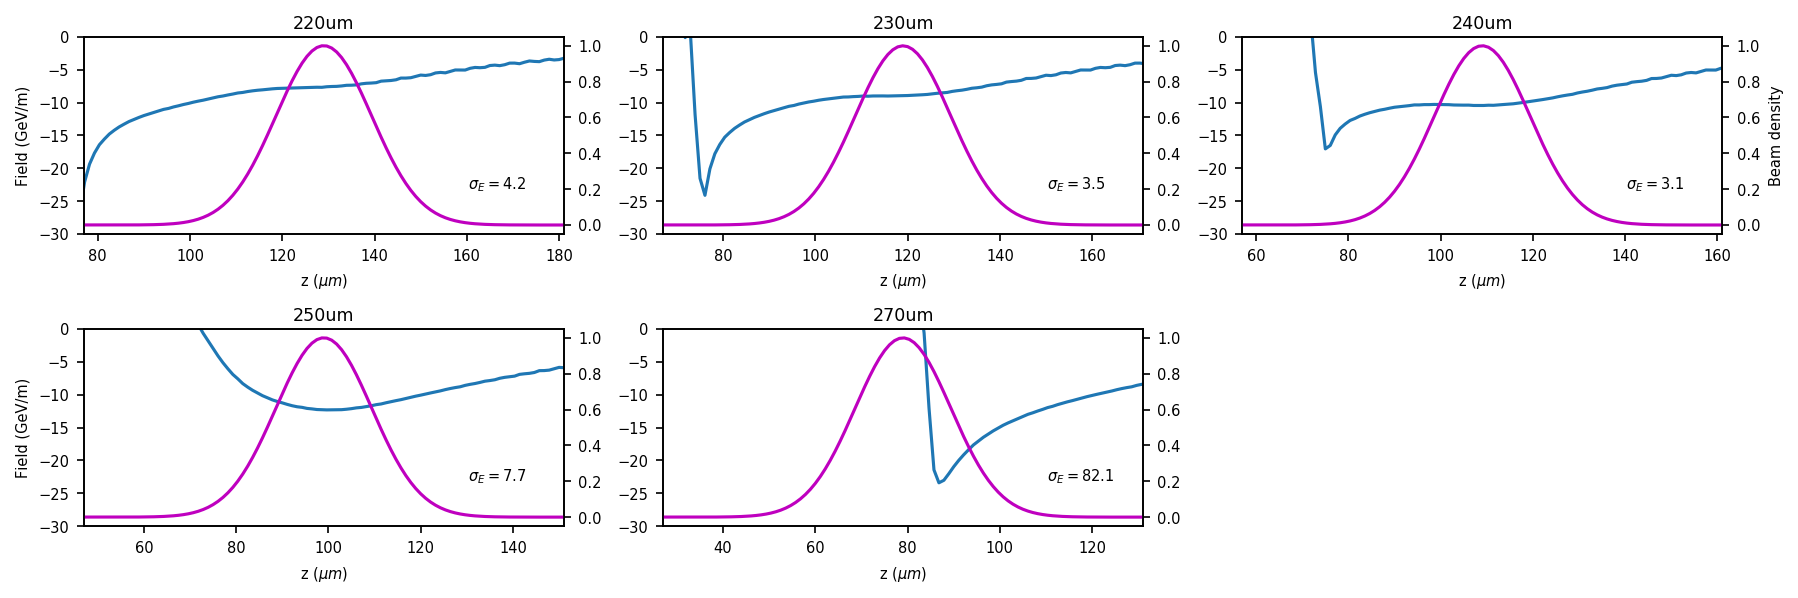

In [11]:
plot_energy_spread(2)

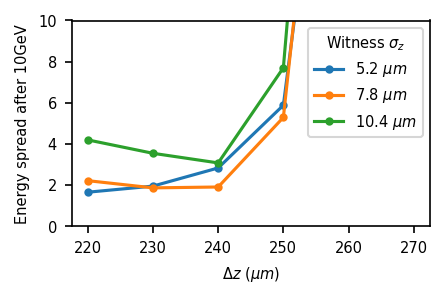

In [12]:
plt.figure(figsize=(3,2), dpi=150)
for i in range(len(beam_sigmaz)):
    plt.plot(witness_delay, spread[i, :], label=(r'%0.1f $\mu m$' % beam_sigmaz[i]), marker='o', markersize=3)
plt.ylabel('Energy spread after 10GeV')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.legend(title=r'Witness $\sigma_z$')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

In [13]:
# Get the energy distributions
# we can look at the histograms to give a better idea of how the energy spread is actually distributed
def plot_energy_dist(i):
    N = len(witness_delay)
    plt.figure(figsize=(12,4), dpi=300)
    gs = gridspec.GridSpec(2, 3)
    
    for j in range(N):
        path = pathPre + '%0dumX%0.1fum/' % (witness_delay[j], beam_sigmaz[i])
        data = np.load(path + 'AcceleratingGradient.npy').item()
        
        k = 6
        # Calculate the standard deviation in energy after acceleration
        center = 300-witness_delay[j]-26
        centerInd = int(center*300/250)
        size = 5*beam_sigmaz[i]
        beamDensity = np.exp(-(data['xfield']*1e6-center)**2/(2*beam_sigmaz[i]**2))
        L = -10/data['field'][k, centerInd]*1e9
        finalE = -data['field'][k, :]/1e9 * L + 10.0
        Eavg = np.average(finalE, weights=beamDensity)
        Estd = np.sqrt(np.average((finalE-Eavg)**2, weights=beamDensity))
        Erel = Estd/Eavg*100
        spread[i ,j] = Erel
        sel = beamDensity > 0.01
        
        plt.subplot(gs[int(j/3), j%3])
        plt.hist(finalE[sel], 1000, weights=beamDensity[sel], range=(-80, 80))
        plt.xlim(finalE[sel].min()*0.95, finalE[sel].max()*1.05)
        #plt.text(2, 0.6, r'$\sigma_E=%0.1f$' % Erel)
        if j%3 == 0:
            plt.ylabel('Number of Particles')
        plt.xlabel('Energy (GeV)')
        plt.title('%0dum' % (witness_delay[j]))
        
    plt.tight_layout()
    plt.show()

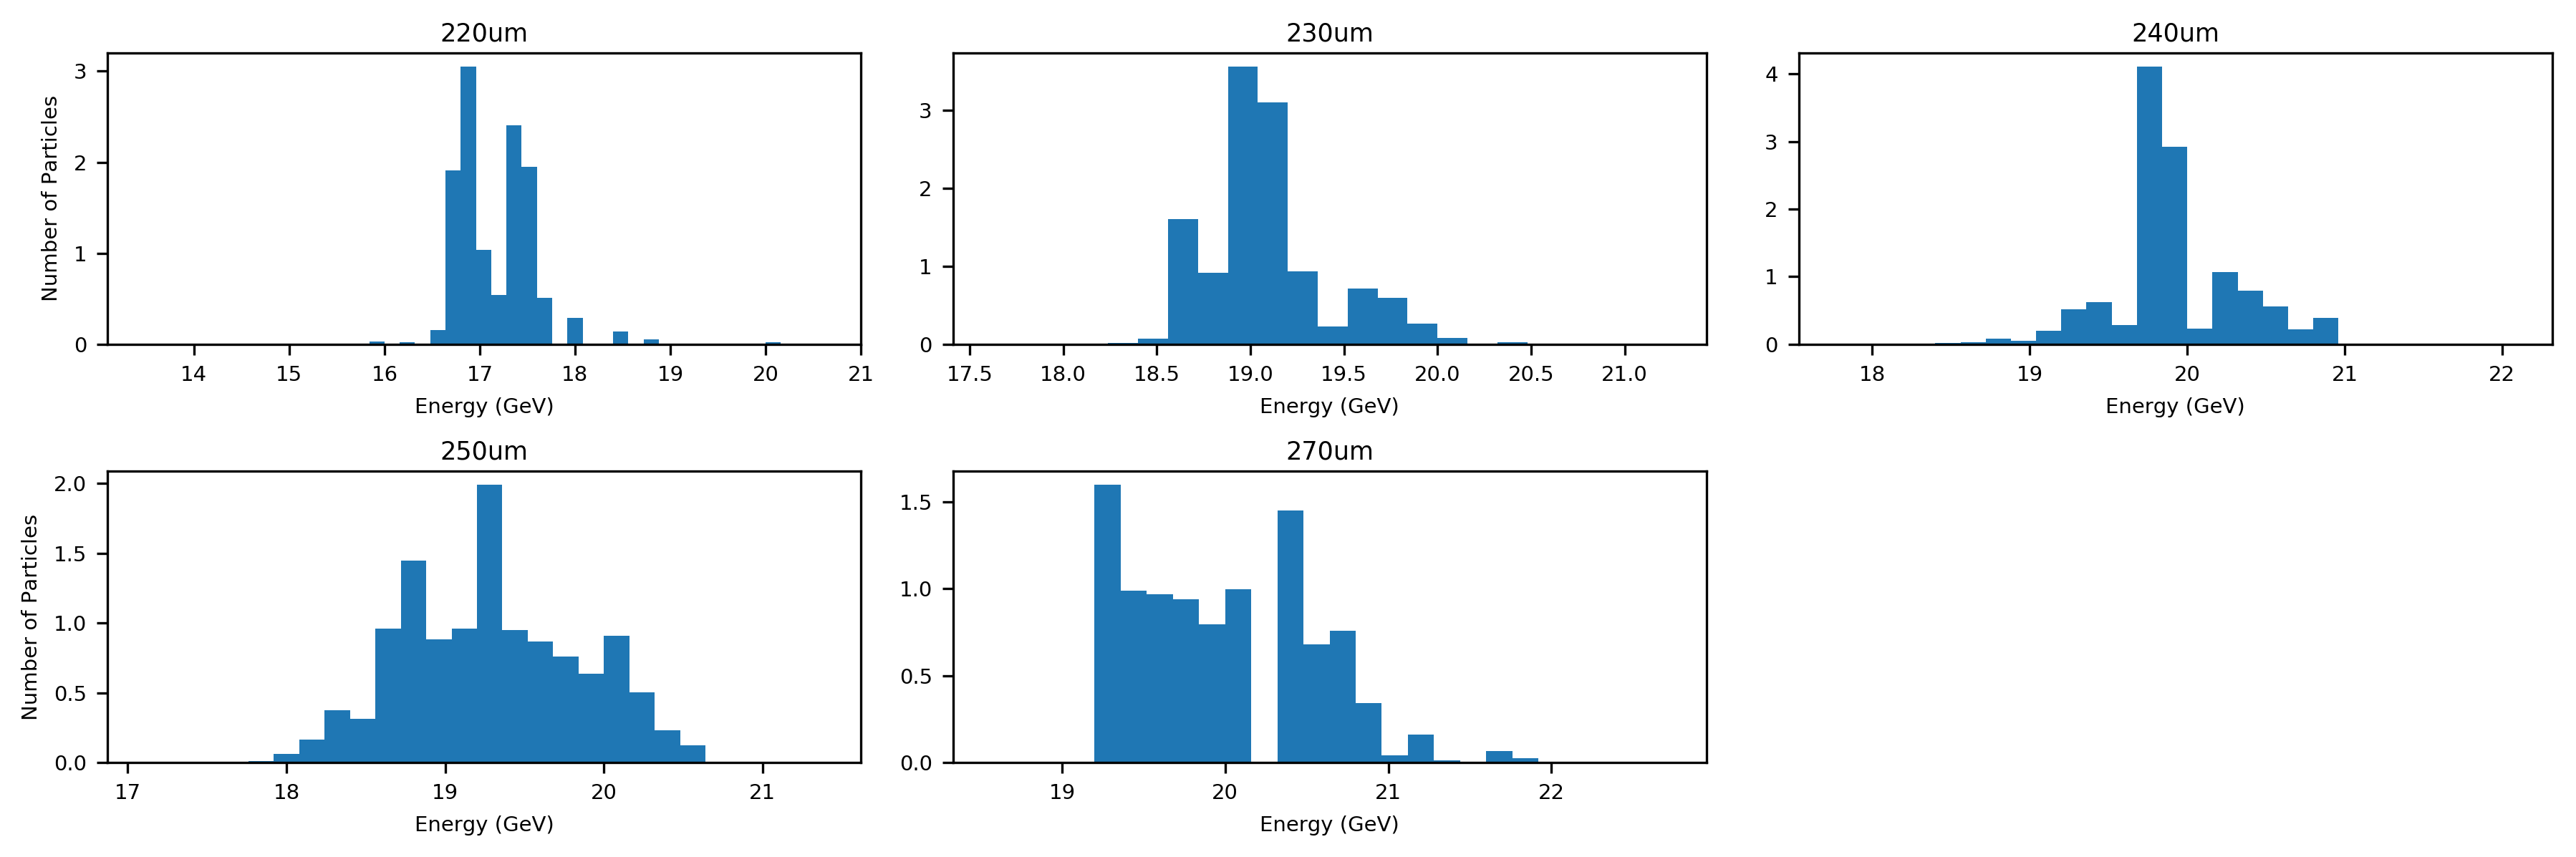

In [14]:
plot_energy_dist(0)

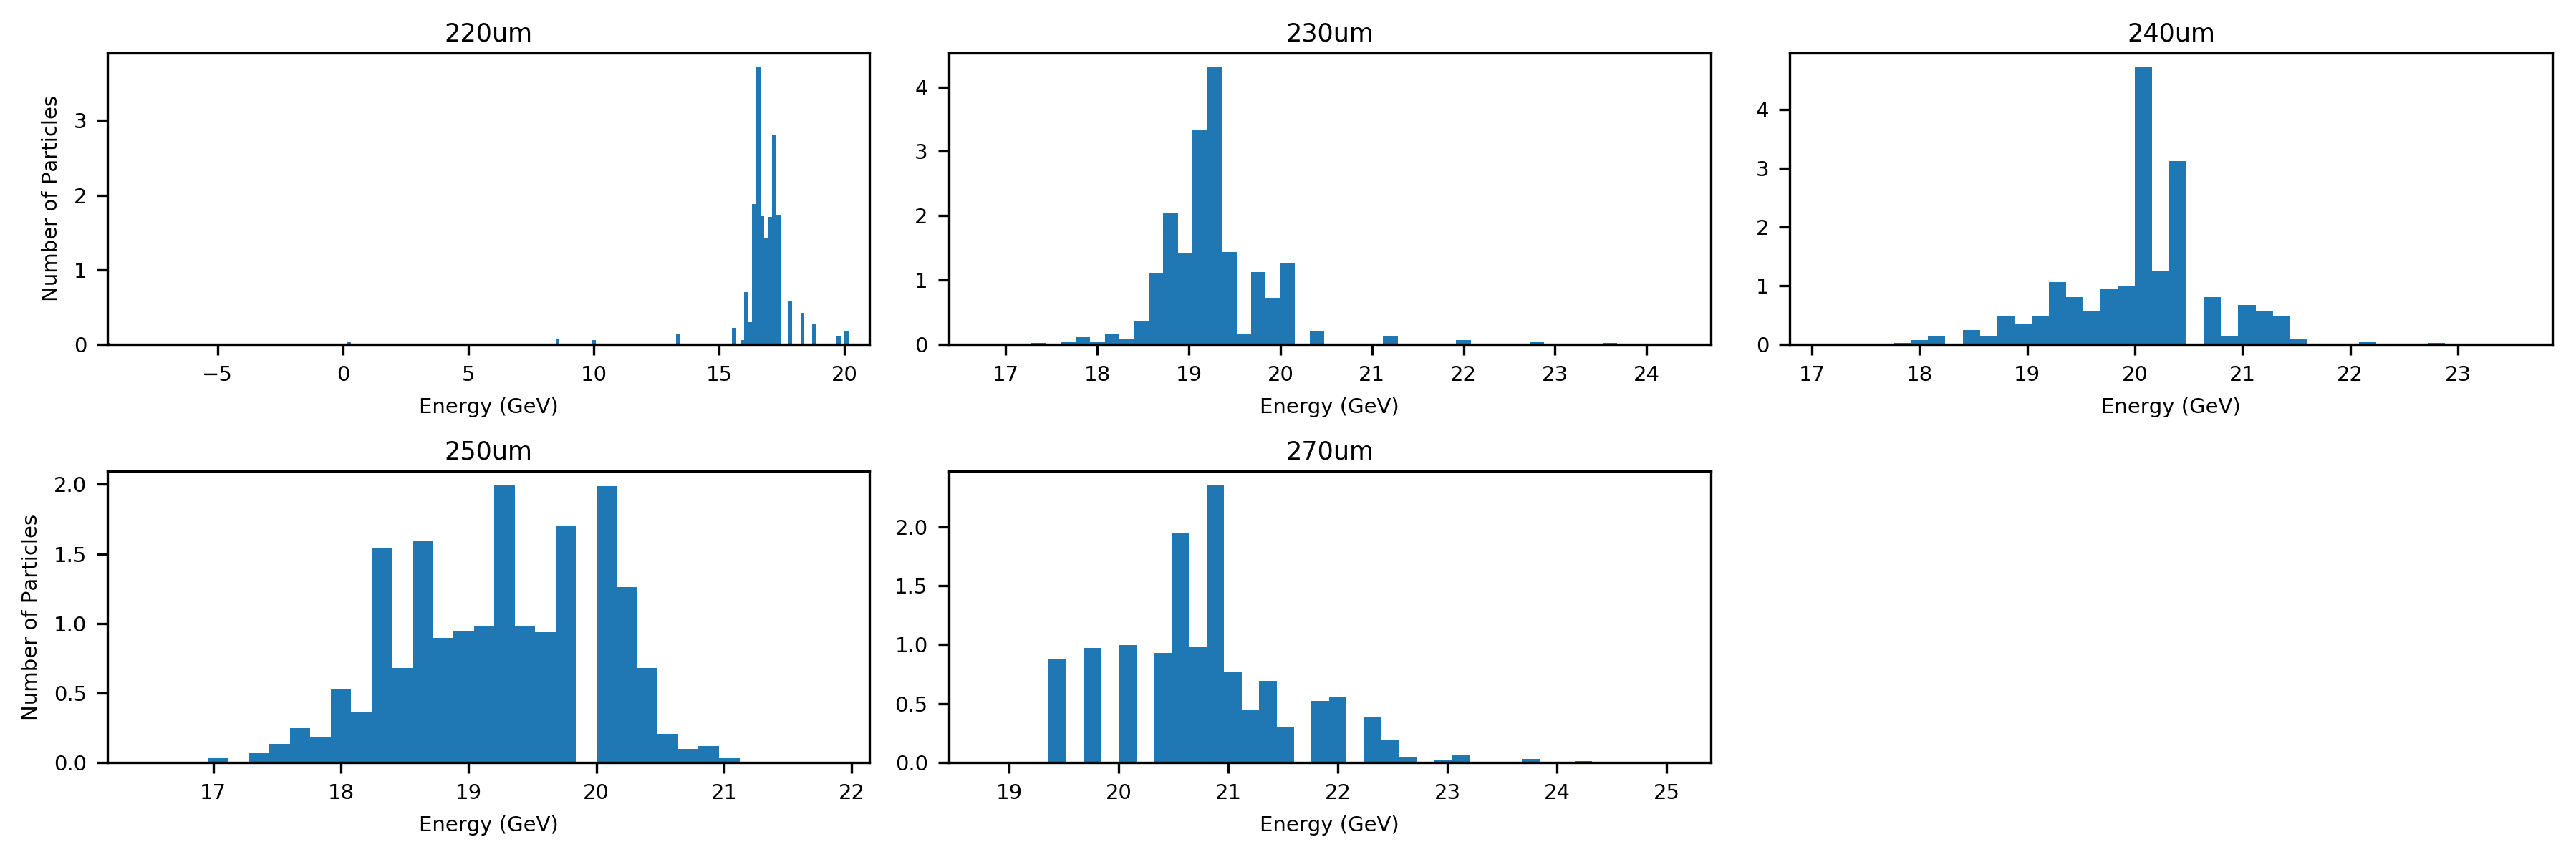

In [15]:
plot_energy_dist(1)

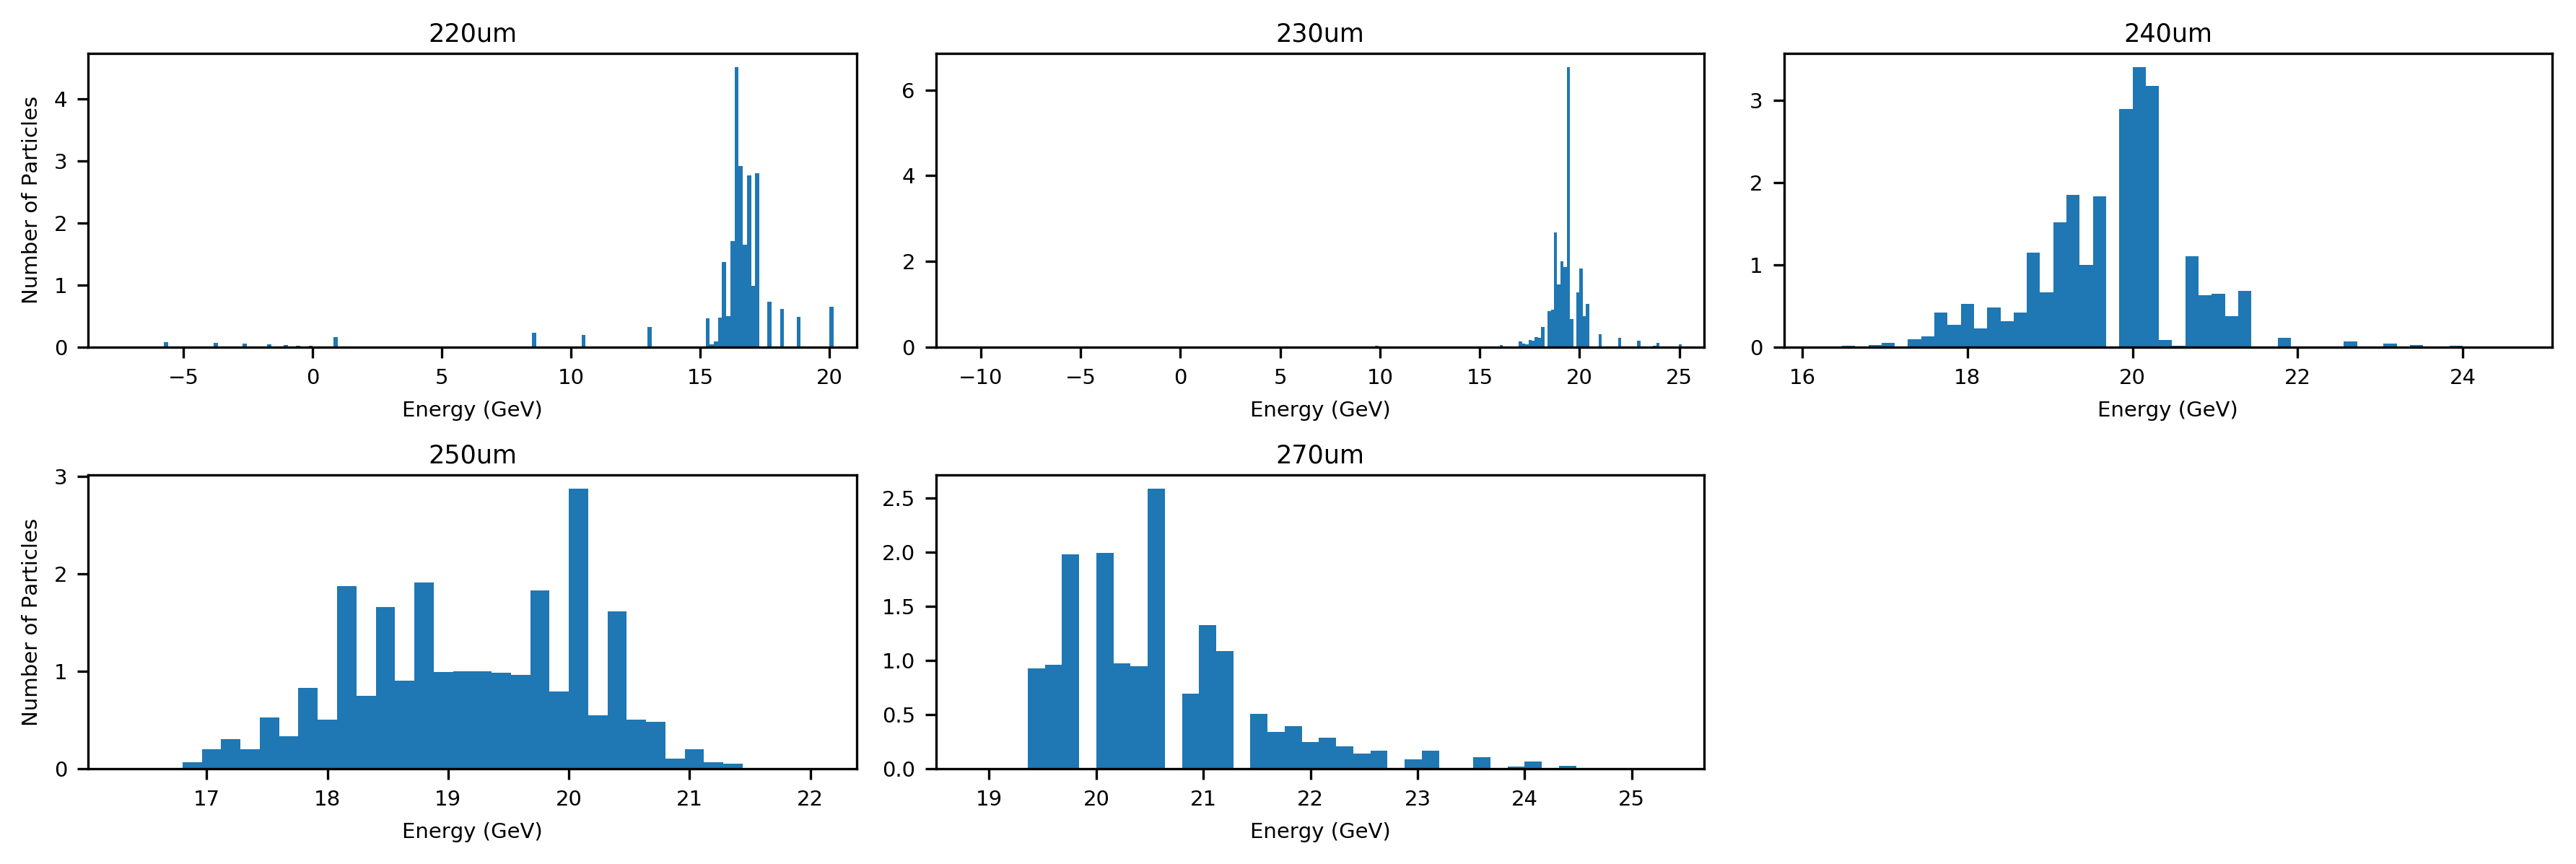

In [16]:
plot_energy_dist(2)